## What is this notebook about?

This notebook was used to create ```Fig.4C```,```Fig.C3D,E``` and the analyis numbers referenced in the text.

The numbers calculated here and other notebooks will be stored under the filepath indicated by the variable `data_reports_fp` for future reference.

In [1]:
# Some imports to get things started
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

sys.path.insert(1, os.path.abspath('/..'))
from utils import set_aspect,save_descriptive_stats, save_variables
from pathlib import Path

In [2]:
# Load the donation info from the data table
donation_table = pd.read_csv(Path('../data/donation_table.csv'))

# Load messages including those from non-interactive chats
messages_table = pd.read_csv(Path('../data/messages_table.csv'))

# Load filtered messages only from interactive chats
messages_filtered_table = pd.read_csv(Path('../data/messages_filtered_table.csv'))

# Load the questionnaire answers 
survey_info = pd.read_excel(Path('../data/survey.xlsx'))

# Where to save numbers from the analysis
data_reports_fp = Path('../reports/numbers.dat')

# Where to save figures from the analysis
figpath = Path('../reports')
# Which colors to use to plot data from different messengers
WhatsApp_color = '#3dc24f'
Facebook_color = '#385999'

In [3]:

def calculate_Barabasi_burstiness(breaks):
    """
    For different burstness measures see Ch.2 in Karsai et al. 2018.
    This measure of burstiness was defined by Goh and Barabasi. 
    
    
    This measure might be affected by the number of events

    Parameters
    ----------
    breaks : array-like
        breaks (in days) between consecutive interactions.

    Returns
    -------
    float 
    burstiness index
       regular --> -1
       Poission random --> 0
       bursty dynamics --> >0, 1 means extremely bursty


    """
    return (np.std(breaks)-np.mean(breaks))/(np.std(breaks)+np.mean(breaks))
    
def calculate_Kim_burstiness(breaks):
    
    """
    For different burstness measures see Ch.2 in Karsai et al. 2018.
    This measure of burstness comes from Kim & Jo 2016 paper
    
    Parameters
    ----------
    breaks : array-like
        breaks (in days) between consecutive interactions.

    Returns
    -------
    float 
    burstiness index
       regular --> -1
       Poission random --> 0
       bursty dynamics --> 1 extremely  bursty


    """

    r = np.std(breaks)/np.mean(breaks)
    n = len(breaks)+1
    B = (np.sqrt(n+1)*r-np.sqrt(n-1))/((np.sqrt(n+1)-2)*r+np.sqrt(n-1))
    return B


In [4]:
# Density plots for Fig. C3D and C3E
def plot_density(barabasi, kim,label,color,figpath):
    from scipy.stats import gaussian_kde
    xy = np.vstack([barabasi,kim])
    xy = pd.DataFrame(xy).T.dropna()

    z = gaussian_kde(xy.T)
    nbins = 120
    xi, yi = np.mgrid[-1:1:nbins*1j, -1:1:nbins*1j]
    zi = z(np.vstack([xi.flatten(), yi.flatten()]))
    fig,ax=plt.subplots()
    ax.pcolormesh(xi,yi, zi.reshape(xi.shape),linewidth=0,rasterized=True)
    ax.plot([0,0],[-1,1],'--',color='gray',alpha=.7)
    ax.plot([-1,1],[0,0],'--',color='gray',alpha=.7)
    ax.plot([-1,1],[-1,1],'--',color='gray',alpha=.7)

    ax.set_xlabel('B1',fontsize=18)
    ax.set_ylabel('B2',fontsize=18)
    set_aspect(ax)
    ax.tick_params(axis='both', which='major', labelsize=14)

    left, bottom, width, height = [0.26, 0.93,0.5, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])
    ax2.hist(barabasi,edgecolor='k',color=color)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_title(label,fontsize=18)
    ax2.set_xlim(-1,1)
    ax2.set_xticks([])

    ax3 = fig.add_axes([0.8, 0.12,0.2, 0.76])
    ax3.hist(kim,edgecolor='k',orientation='horizontal',color=color)
    ax3.set_ylim(-1,1)
    ax3.set_yticks([])
    ax3.tick_params(axis='both', which='major', labelsize=12)
    fig.savefig(Path(f'{figpath}/burstiness_{label}.svg'),
                dpi=500,bbox_inches = 'tight')
    fig.savefig(Path(f'{figpath}/burstiness_{label}.png'),
                dpi=500,bbox_inches = 'tight')


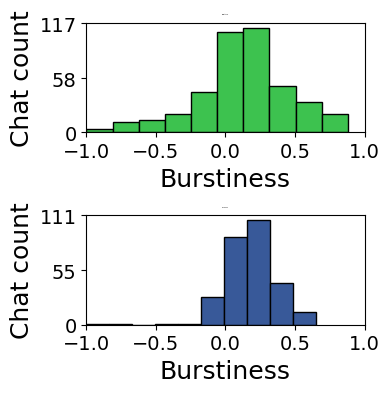

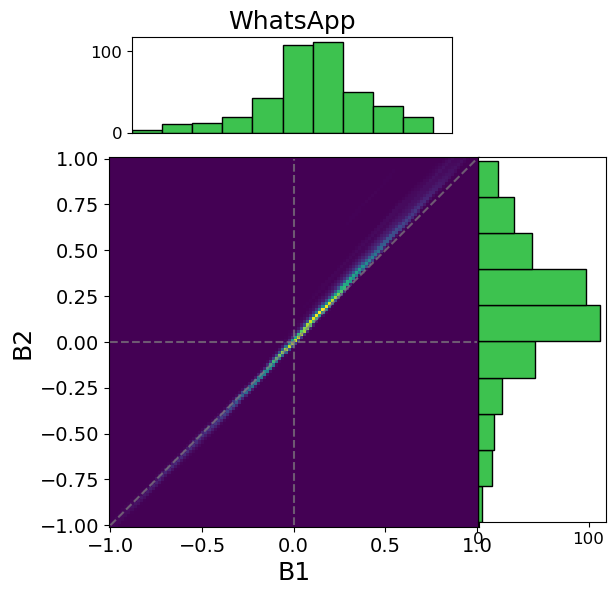

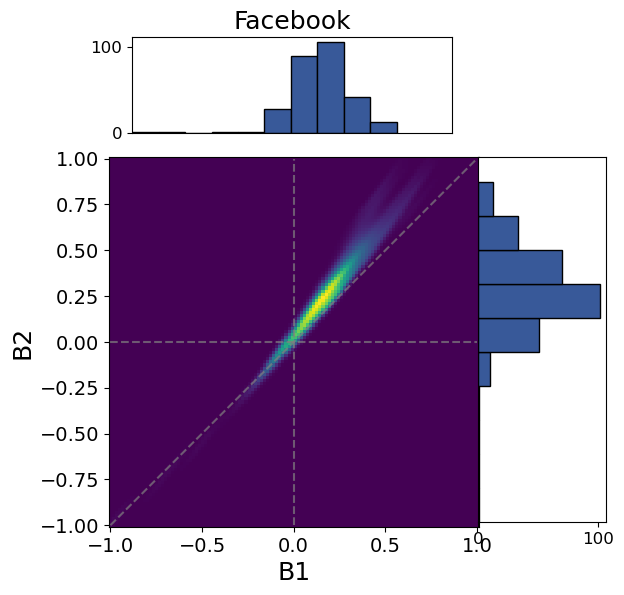

In [5]:
# Assign empty lists to store values for each burstiness metric
barabasi_burstiness = []
kim_burstiness = []

# Iterate through sources, plot histograms and save stats
fig, axes = plt.subplots(2,1,figsize=(4,4))
for ind, (source, color) in enumerate(zip(['WhatsApp','Facebook'], [WhatsApp_color, Facebook_color])):    
    sourceIDs = donation_table[donation_table['source'] == source]['donation_id']
    source_messages = messages_filtered_table[messages_filtered_table['donation_id'].isin(sourceIDs)]
    
    # Group by 'conversation_id' and split into separate dataframes
    grouped = source_messages.groupby('conversation_id')
    
    # Create a dictionary of dataframes
    chats_df = [group for _, group in grouped]
    
    # Empty lists to store values for the source for sample stats
    source_barabasi_burstiness = []
    source_kim_burstiness = []
    
    # Iterate through chats and calculate interaction burstiness
    for chat in chats_df:
        chat['datetime'] = pd.to_datetime(chat['datetime']) # make sure the date has the right format
        sorted_chat = chat.sort_values(by='datetime').reset_index(drop=True)
        sorted_chat.set_index('datetime', inplace=True) 
        # Resample by days to have days when and interaction happens + total wordcount per day
        resampled_chat = sorted_chat.resample('D').sum() 
        resampled_chat = resampled_chat.loc[~(resampled_chat==0).all(axis=1)] # remove zeros, i.e. days with no interactions
        
        # Only consider chats with more than 10 interaction days
        if len(resampled_chat) >= 10:
            # Breaks between interaction days
            days_passed = resampled_chat.index.to_series().diff().dt.days
            
            # Calculte the two burstiness metrics
            barabasi_burst = calculate_Barabasi_burstiness(days_passed)
            kim_burst = calculate_Kim_burstiness(days_passed)
            
            # Appending to calculate stats later
            barabasi_burstiness.append(barabasi_burst)
            kim_burstiness.append(kim_burst)
            source_barabasi_burstiness.append(barabasi_burst)
            source_kim_burstiness.append(kim_burst)
    
    # Plot the histograms in Fig. 4C        
    ax = axes[ind]
    ax.hist(source_barabasi_burstiness,color=color,edgecolor='k')
    ax.set_title(source,fontsize=1)
    ax.set_xlabel('Burstiness',fontsize=18)
    ax.set_ylabel('Chat count',fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xlim([-1,1])
    ax.set_yticks(np.linspace(ax.get_ylim()[0],ax.get_ylim()[-1],3,dtype=int))
    
    # Plot the density plots in Fig. C3
    plot_density(source_barabasi_burstiness,source_kim_burstiness,source,color,figpath)
    
    # Calculate and save stats for each burstiness metric for the source
    save_descriptive_stats(data_reports_fp,f'{source}_Barabasi',source_barabasi_burstiness)
    save_descriptive_stats(data_reports_fp,f'{source}_Kim',source_kim_burstiness)
    
    # Calculate and save the proportion of chats with a positive bursiness value, i.e. chats with bursty dynamics
    positive_proportion = len([item for item in source_barabasi_burstiness if item>0])/len(source_barabasi_burstiness)
    save_variables(data_reports_fp,f'{source}_Barabasi-positive-percent',positive_proportion*100)
    
fig.patch.set_facecolor('white')
fig.tight_layout()
fig.savefig(Path(f'{figpath}/burstiness-hist.svg'),
                dpi=500,bbox_inches = 'tight')
fig.savefig(Path(f'{figpath}/burstiness-hist.png'),
                dpi=500,bbox_inches = 'tight')


# Calculate and save descriptive stats for both bursiness metrics
save_descriptive_stats(data_reports_fp,f'all_Barabasi',barabasi_burstiness)
save_descriptive_stats(data_reports_fp,f'all_Kim',kim_burstiness)